In [9]:
%matplotlib inline
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np


kernels = ['linear', 'rbf', 'poly']
def run_svm_with_feature_selection(results, X_encoded, Y, file_name, k_features=10):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

    best_model = None
    best_score = -1
    best_kernel = ""
    best_pipeline = None
    best_selector = None
    feature_names = X_encoded.columns

    for kernel in kernels:
        # Build pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('select', SelectKBest(score_func=f_classif, k=k_features)),
            ('svm', SVC(kernel=kernel, C = 1))
        ])

        # Train
        pipeline.fit(X_train, y_train)

        # Predict
        y_pred = pipeline.predict(X_test)

        # Evaluate
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy ({kernel}):", acc)
        cm = confusion_matrix(y_test, y_pred)

        if acc > best_score:
            best_score = acc
            best_model = pipeline.named_steps['svm']
            best_pipeline = pipeline
            best_selector = pipeline.named_steps['select']
            best_kernel = kernel

        results[kernel] = (acc, cm, pipeline)

    if best_pipeline is not None:
        print("Best score found with kernel:", best_kernel)

        # Get selected feature names
        selected_indices = best_selector.get_support(indices=True)
        selected_feature_names = feature_names[selected_indices]

        print(selected_feature_names)

        disp = ConfusionMatrixDisplay(confusion_matrix=results[best_kernel][1])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix: ')
        plt.show()
        



def graph_svm_results(results_arr, file_name_base, results_names = None):
    plt.figure(figsize=(6, 5))

    i = 0
    for r_dict in results_arr:
        x_arr = []
        y_arr = []
        for k, v in r_dict.items():
            x_arr.append(k)
            y_arr.append(v[0])
            
        if results_names:
            plt.plot(x_arr, y_arr, marker='o', linestyle='-', linewidth=2, label=results_names[i])
            i += 1
        else:
            plt.plot(x_arr, y_arr,  marker='o', linestyle='-', linewidth=2)

    plt.title('Accuracy vs K')
    plt.xlabel('K')
    plt.ylabel('Accuracy Score')

    if results_names:
        plt.legend()

    plt.tight_layout()
    plt.savefig(file_name_base, bbox_inches='tight')
    plt.show()

Accuracy (linear): 0.8106060606060606
Accuracy (rbf): 0.8257575757575758
Accuracy (poly): 0.7651515151515151
Best score found with kernel: rbf
Index([' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Persistent EPS in the Last Four Seasons',
       ' Per Share Net profit before tax (Yuan ¥)', ' Debt ratio %',
       ' Net worth/Assets', ' Net profit before tax/Paid-in capital',
       ' Working Capital to Total Assets', ' Net Income to Total Assets'],
      dtype='object')


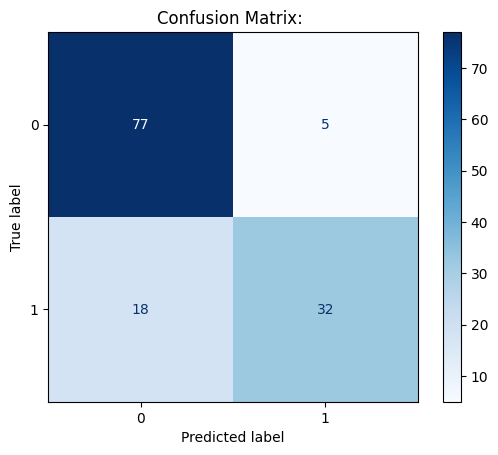

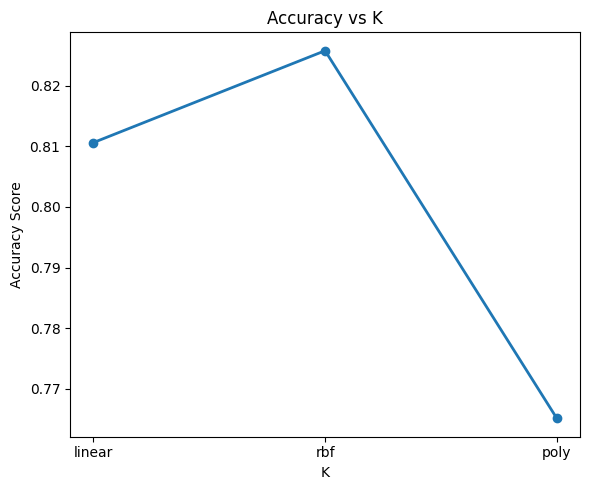

In [10]:
import pandas as pd

# Load CSV
df = pd.read_csv('bankruptcy_data.csv')

# Separate based on the target
bankrupt_df = df[df['Bankrupt?'] == 1]
not_bankrupt_df = df[df['Bankrupt?'] == 0]

# How many bankrupt samples
n_bankrupt = len(bankrupt_df)

# Sample 2x that from the not-bankrupt class
not_bankrupt_sampled = not_bankrupt_df.sample(n=2 * n_bankrupt, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([bankrupt_df, not_bankrupt_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# If you want the X and Y split again:
X = balanced_df.drop(['Bankrupt?', ' Net Income Flag', ' Liability-Assets Flag'], axis=1)
Y = balanced_df['Bankrupt?']


# Run the algorithm
full_results = {}
run_svm_with_feature_selection(full_results, X, Y, "bankrupcy_svm_")
graph_svm_results([full_results], "bankrupcy_svm_all")